# Анализ результатов АБ-теста
В данном задании вам нужно будет

- проанализировать АБ тест, проведенный на реальных пользователях Яндекса
- подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
- определить характер этих изменений и практическую значимость вводимого изменения
- понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)

In [113]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/alina/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mean', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Описание данных:

- userID: уникальный идентификатор пользователя
- browser: браузер, который использовал userID
- slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
- n_clicks: количество кликов, которые пользоваль совершил за n_queries
- n_queries: количество запросов, который совершил userID, пользуясь браузером browser
- n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.



In [114]:
data = pd.read_csv('ab_browser_test.csv', sep = ',')

In [115]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


### 1
Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки.

In [116]:
data.describe()

,userID,n_clicks,n_queries,n_nonclk_queries
count,566134.000000,566134.000000,566134.000000,566134.000000
mean,301377.214027,11.431658,10.720524,4.703987
std,175526.333101,20.251494,16.262827,8.109958
min,1.000000,0.000000,1.000000,0.000000
25%,148627.250000,1.000000,2.000000,1.000000
50%,299362.500000,4.000000,5.000000,2.000000
75%,455698.750000,13.000000,13.000000,6.000000
max,603137.000000,863.000000,665.000000,581.000000


In [117]:
n_clikcks_exp = sum(list(data[data.slot == 'exp'].n_clicks))
n_clikcks_control = sum(list(data[data.slot == 'control'].n_clicks))
delta = n_clikcks_exp*1./n_clikcks_control*100-100
delta

1.6135689824415778

### 2
Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп.

In [118]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [119]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [120]:
np.random.seed(0)

median_exp = list(map(np.median, get_bootstrap_samples(data[data.slot == 'exp'].n_clicks.values, 1000)))
median_control = list(map(np.median, get_bootstrap_samples(data[data.slot == 'control'].n_clicks.values, 1000)))

print("95% confidence interval for exp median:",  stat_intervals(median_exp, 0.05))
print("95% confidence interval for control median:",  stat_intervals(median_control, 0.05))

95% confidence interval for exp median: [5. 5.]
95% confidence interval for control median: [4. 4.]


In [121]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(median_exp, median_control)))

print("difference between medians:", np.median(data[data.slot == 'exp'].n_clicks.values) -
                                        np.median(data[data.slot == 'control'].n_clicks.values))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

difference between medians: 1.0
95% confidence interval for the difference between medians [-1. -1.]


In [122]:
np.random.seed(0)

mean_exp = list(map(np.mean, get_bootstrap_samples(data[data.slot == 'exp'].n_clicks.values, 1000)))
mean_control = list(map(np.mean, get_bootstrap_samples(data[data.slot == 'control'].n_clicks.values, 1000)))

print("95% confidence interval for exp mean:",  stat_intervals(mean_exp, 0.05))
print("95% confidence interval for control mean:",  stat_intervals(mean_control, 0.05))

95% confidence interval for exp mean: [11.5086867  11.66089388]
95% confidence interval for control mean: [11.20795095 11.35742732]


In [123]:
delta_mean_scores = list(map(lambda x: x[1] - x[0], zip(mean_exp, mean_control)))

print("difference between means:", np.mean(data[data.slot == 'exp'].n_clicks.values) -
                                        np.mean(data[data.slot == 'control'].n_clicks.values))
print("95% confidence interval for the difference between means",  stat_intervals(delta_mean_scores, 0.05))

difference between means: 0.3030947340656329
95% confidence interval for the difference between means [-0.40475697 -0.19172563]


### 3
Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

In [124]:
from scipy import stats

((array([-4.57023359, -4.38078026, -4.27804676, ...,  4.27804676,
          4.38078026,  4.57023359]),
  array([  0,   0,   0, ..., 627, 773, 863])),
 (14.864475170767355, 11.280906260323171, 0.7328783997528365))

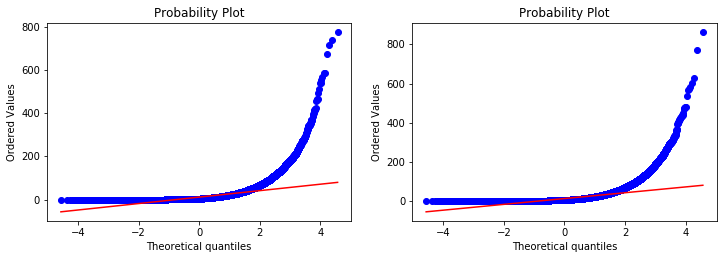

In [125]:
plt.figure(figsize = (12, 8))

plt.subplot(2, 2, 1)
stats.probplot(data[data.slot == 'exp'].n_clicks, dist="norm", plot=pylab)

plt.subplot(2, 2, 2)
stats.probplot(data[data.slot == 'control'].n_clicks, dist="norm", plot=pylab)

Распределения не являются нормальными, потому что Q-Q графики не лежат на прямой

### 4
t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных.

Для простоты рассмотрим одновыборочный t-критерий. Его статистика имеет вид $\frac{X_{mean} - \mu}{\sqrt{S^2/n}}$, то есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:
- $X_{mean}$ — среднее значение в выборке — было распределено нормально 
- $\frac{n}{\sigma^2}S^2$ — несмещенная оценка дисперсии c масштабирующим коэффициентом — была распределена по хи-квадрат c n−1 степенями свободы

Простое доказательство необходимости и достаточности этого требования можно посмотреть в самом последнем абзаце этого вопроса. Усвоение этого доказательства не обязательно для выполнения задания.

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого

1. Получите из данных n_boot_samples псевдовыборок.

2. По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)

3. Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения

4. Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения с помощью команды scipy.stats.probplot(control_boot_chi_squared, dist="chi2", sparams=(n-1), plot=plt)

Где sparams=(n-1) означают число степеней свободы = длине выборки - 1.

Чтобы получить такой же ответ, как у нас, зафиксируйте seed и количество псевдовыборок:
- np.random.seed(0)
- n_boot_samples = 500

В качестве ответа отметьте верные утвердения о значениях $R^2$, которые генерирует scipy.stats.probplot при отображении qq-графиков: одно c графика для среднего и одно с графика для выборочной суммы квадратов отклонения от выборочной суммы.





In [126]:
np.random.seed(0)
n_boot_samples = 500

samples = get_bootstrap_samples(data[data.slot == 'control'].n_clicks.values, n_boot_samples)

mean = list(map(np.mean, samples))
control_boot_chi_squared = list(map(np.std, samples))



((array([-2.99209858e+00, -2.71015927e+00, -2.55162541e+00, -2.43921385e+00,
         -2.35113311e+00, -2.27822091e+00, -2.21572267e+00, -2.16084152e+00,
         -2.11178767e+00, -2.06734403e+00, -2.02664403e+00, -1.98904794e+00,
         -1.95406954e+00, -1.92133033e+00, -1.89052965e+00, -1.86142459e+00,
         -1.83381593e+00, -1.80753820e+00, -1.78245240e+00, -1.75844061e+00,
         -1.73540186e+00, -1.71324904e+00, -1.69190643e+00, -1.67130780e+00,
         -1.65139483e+00, -1.63211595e+00, -1.61342528e+00, -1.59528183e+00,
         -1.57764883e+00, -1.56049314e+00, -1.54378481e+00, -1.52749667e+00,
         -1.51160399e+00, -1.49608418e+00, -1.48091659e+00, -1.46608224e+00,
         -1.45156367e+00, -1.43734479e+00, -1.42341071e+00, -1.40974764e+00,
         -1.39634279e+00, -1.38318426e+00, -1.37026095e+00, -1.35756253e+00,
         -1.34507932e+00, -1.33280226e+00, -1.32072287e+00, -1.30883317e+00,
         -1.29712567e+00, -1.28559331e+00, -1.27422944e+00, -1.26302778e+00,

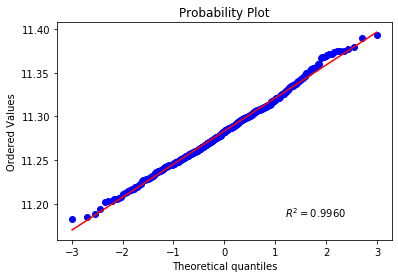

In [127]:
plt.figure()
stats.probplot(mean, dist="norm", plot=pylab, rvalue=True)

((array([409.75447609, 417.6076492 , 422.06789456, 425.24996033,
         427.75458277, 429.83540071, 431.6244473 , 433.19958802,
         434.61075771, 435.89197548, 437.06750372, 438.15527962,
         439.16895419, 440.11916758, 441.0143809 , 441.86143812,
         442.66595697, 443.43260794, 444.16531782, 444.86742108,
         445.54177438, 446.19084464, 446.81677748, 447.42145127,
         448.00652022, 448.57344901, 449.12354099, 449.6579613 ,
         450.17775596, 450.68386771, 451.17714938, 451.65837504,
         452.12824958, 452.58741674, 453.03646615, 453.47593922,
         453.90633437, 454.32811152, 454.74169597, 455.14748186,
         455.54583518, 455.93709642, 456.3215829 , 456.69959087,
         457.07139736, 457.43726183, 457.79742761, 458.1521233 ,
         458.50156388, 458.84595184, 459.1854781 , 459.52032292,
         459.85065667, 460.17664058, 460.49842735, 460.81616179,
         461.12998133, 461.44001656, 461.74639164, 462.04922476,
         462.3486285 , 46

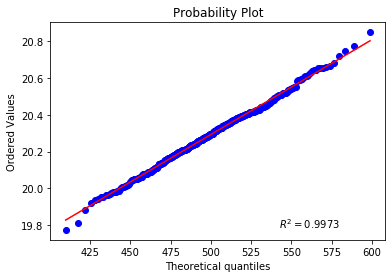

In [128]:
plt.figure()
stats.probplot(control_boot_chi_squared, dist="chi2", sparams=(len(control_boot_chi_squared)-1), plot=plt, rvalue=True)

### 5
Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы


In [129]:
data_exp = data[data.slot == 'exp']
data_control = data[data.slot == 'control']

In [130]:
data_exp_new = data_exp.groupby(['userID']).sum()
data_control_new = data_control.groupby(['userID']).sum()

In [131]:
stats.mannwhitneyu(data_exp_new.n_clicks, data_control_new.n_clicks)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

### 6
Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с α=0.05.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [132]:
browsers = list(set(data.browser))
browsers

['Browser #17',
 'Browser #22',
 'Browser #4',
 'Browser #14',
 'Browser #20',
 'Browser #2']

In [133]:
pvals = []
for b in browsers:
    res = stats.mannwhitneyu(data_exp[data_exp.browser == b].n_clicks, 
                             data_control[data_control.browser == b].n_clicks)
    print(b, res)
    pvals.append(res.pvalue)
print(pvals)

Browser #17 MannwhitneyuResult(statistic=131389681.0, pvalue=0.03740060143010802)
Browser #22 MannwhitneyuResult(statistic=2547597959.5, pvalue=0.2574055152210032)
Browser #4 MannwhitneyuResult(statistic=3072447765.0, pvalue=0.40760617658454984)
Browser #14 MannwhitneyuResult(statistic=806984730.5, pvalue=0.0)
Browser #20 MannwhitneyuResult(statistic=143791805.0, pvalue=0.45366656388735377)
Browser #2 MannwhitneyuResult(statistic=1522572720.0, pvalue=0.0272438604197241)
[0.03740060143010802, 0.2574055152210032, 0.40760617658454984, 0.0, 0.45366656388735377, 0.0272438604197241]


In [134]:
from statsmodels import *

In [136]:
stats.multitest.multipletests(pvals, alpha=0.05, method='holm', is_sorted=False, returnsorted=False)

(array([False, False, False,  True, False, False]),
 array([0.14960241, 0.77221655, 0.81521235, 0.        , 0.81521235,
        0.1362193 ]),
 0.008512444610847103,
 0.008333333333333333)

### 7
Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? Отметьте все верные утверждения.

In [137]:
data_exp.n_nonclk_queries.sum()/data_exp.n_queries.sum()*100

42.69887343806424

In [139]:
data_control.n_nonclk_queries.sum()/data_control.n_queries.sum()*100

45.0179084208453

In [140]:
for b in browsers:
    print(b, data_exp[data_exp.browser == b].n_nonclk_queries.sum()/data_exp[data_exp.browser == b].n_queries.sum()*100)

Browser #17 36.93741284866483
Browser #22 39.85394721969546
Browser #4 45.14294190358467
Browser #14 43.755617361273295
Browser #20 38.97737648371716
Browser #2 44.982746948554706


In [141]:
for b in browsers:
    print(b, data_control[data_control.browser == b].n_nonclk_queries.sum()/data_control[data_control.browser == b].n_queries.sum()*100)

Browser #17 36.29936674628208
Browser #22 40.593976593513354
Browser #4 46.97092963514274
Browser #14 57.59041136008114
Browser #20 40.540484743383296
Browser #2 45.96274717919465
